# Sine Potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from hamilton_class import HamiltonSystem
from nambu_class import NambuSystem
from plot_class import Plotter

### Single initial condition using Hamiltonian System

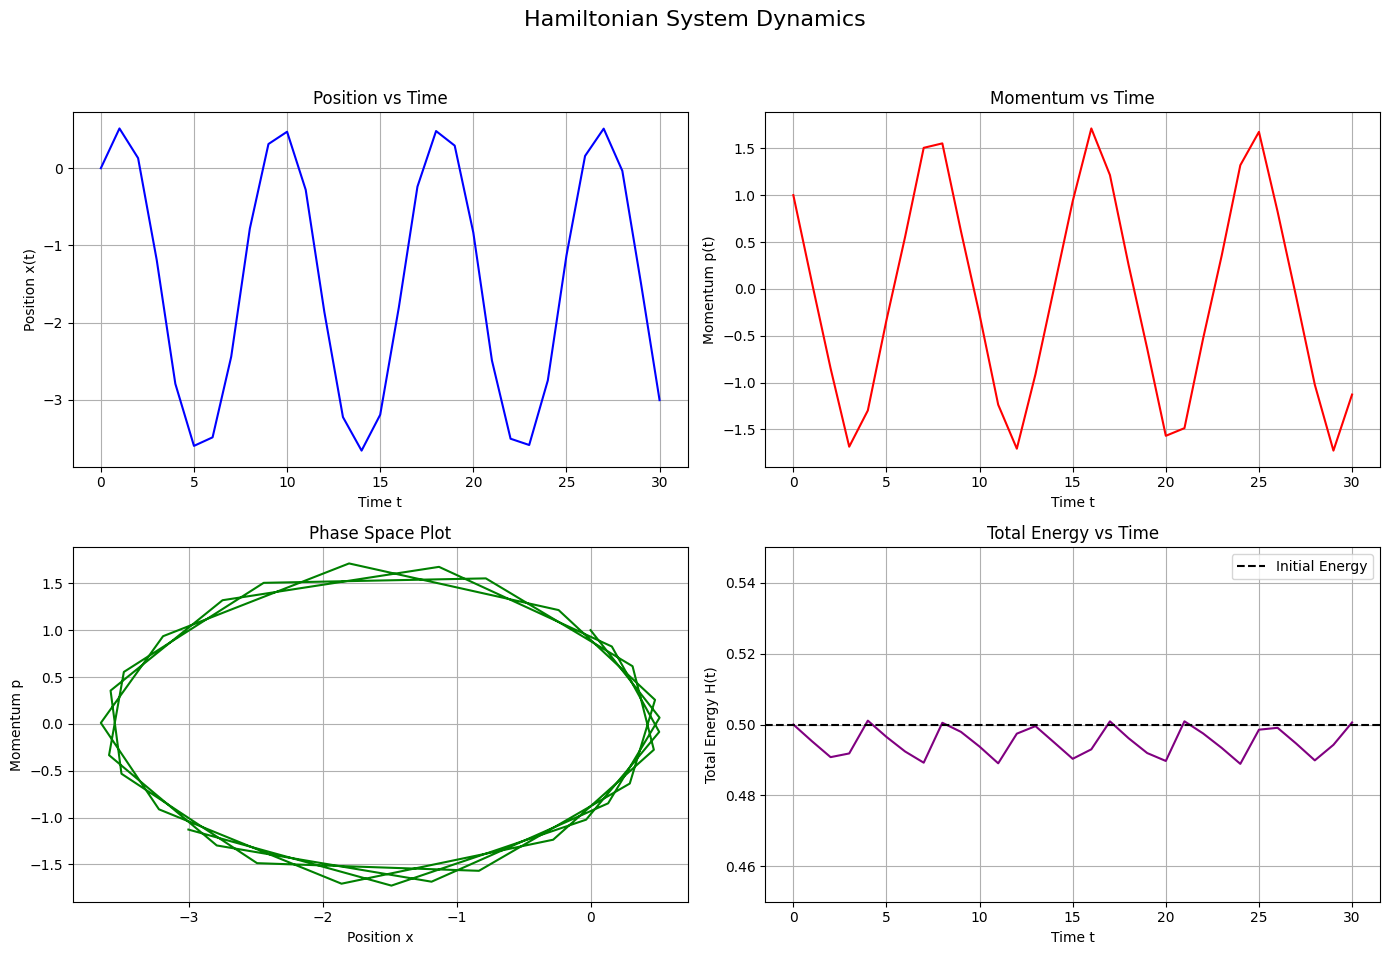

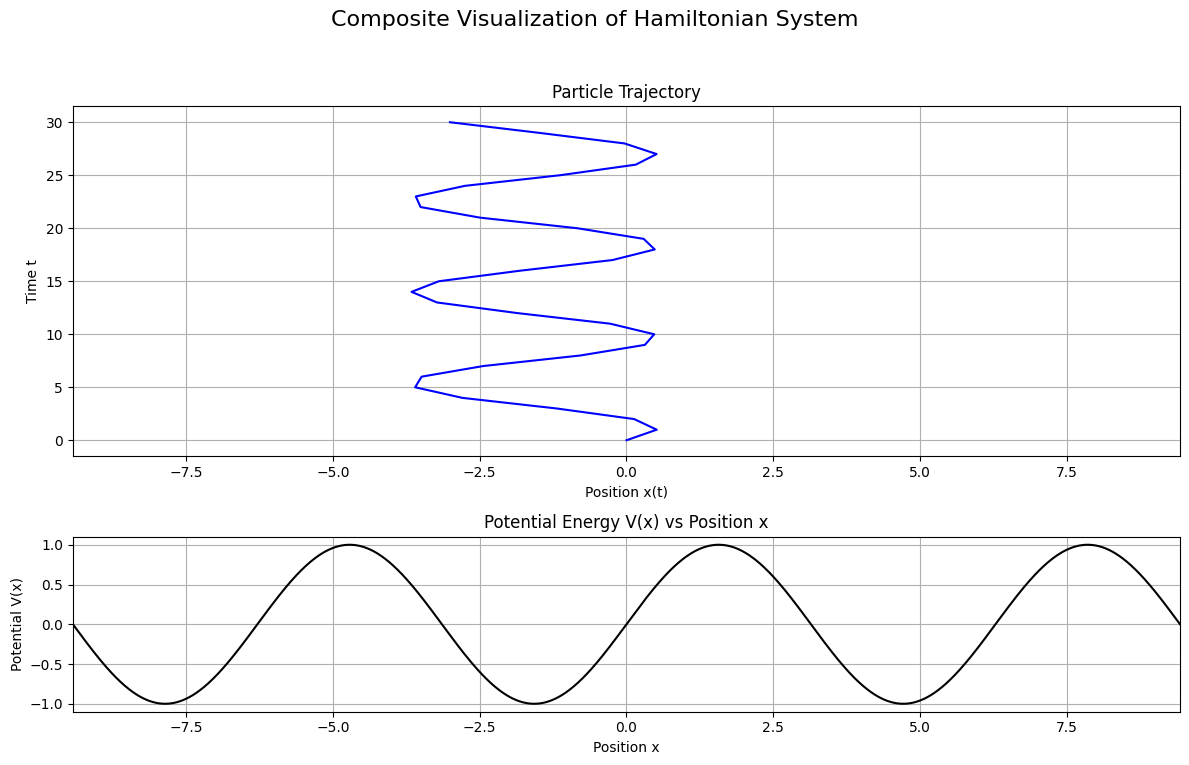

In [2]:
# Define the parameters
m = 1.0  # Mass
t_max = 30.0  # Maximum time
delta_t = 0.01  # Time step

def p_dot(x, p):
    return - np.cos(x)  # For sine potential, dp/dt = -cos(x)

def x_dot(x, p):
    return p / m  # For sine potential, dx/dt = p / m

# Create Hamiltonian system
hamilton_system = HamiltonSystem(p_dot, x_dot, t_max, delta_t)

# Fixed initial condition
x0, p0 = 0.0, 1.0

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)

# Sample the data
t_sampled, x_sampled, p_sampled = hamilton_system.sample_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = 0.5 * (p_sampled**2) / m + np.sin(x_sampled)
potential = lambda x: np.sin(x)

# Plotting
plotter = Plotter()
plotter.static_plots(t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.composite_plot(x_sampled, t_sampled, potential)

### Single initial condition using Nambu System

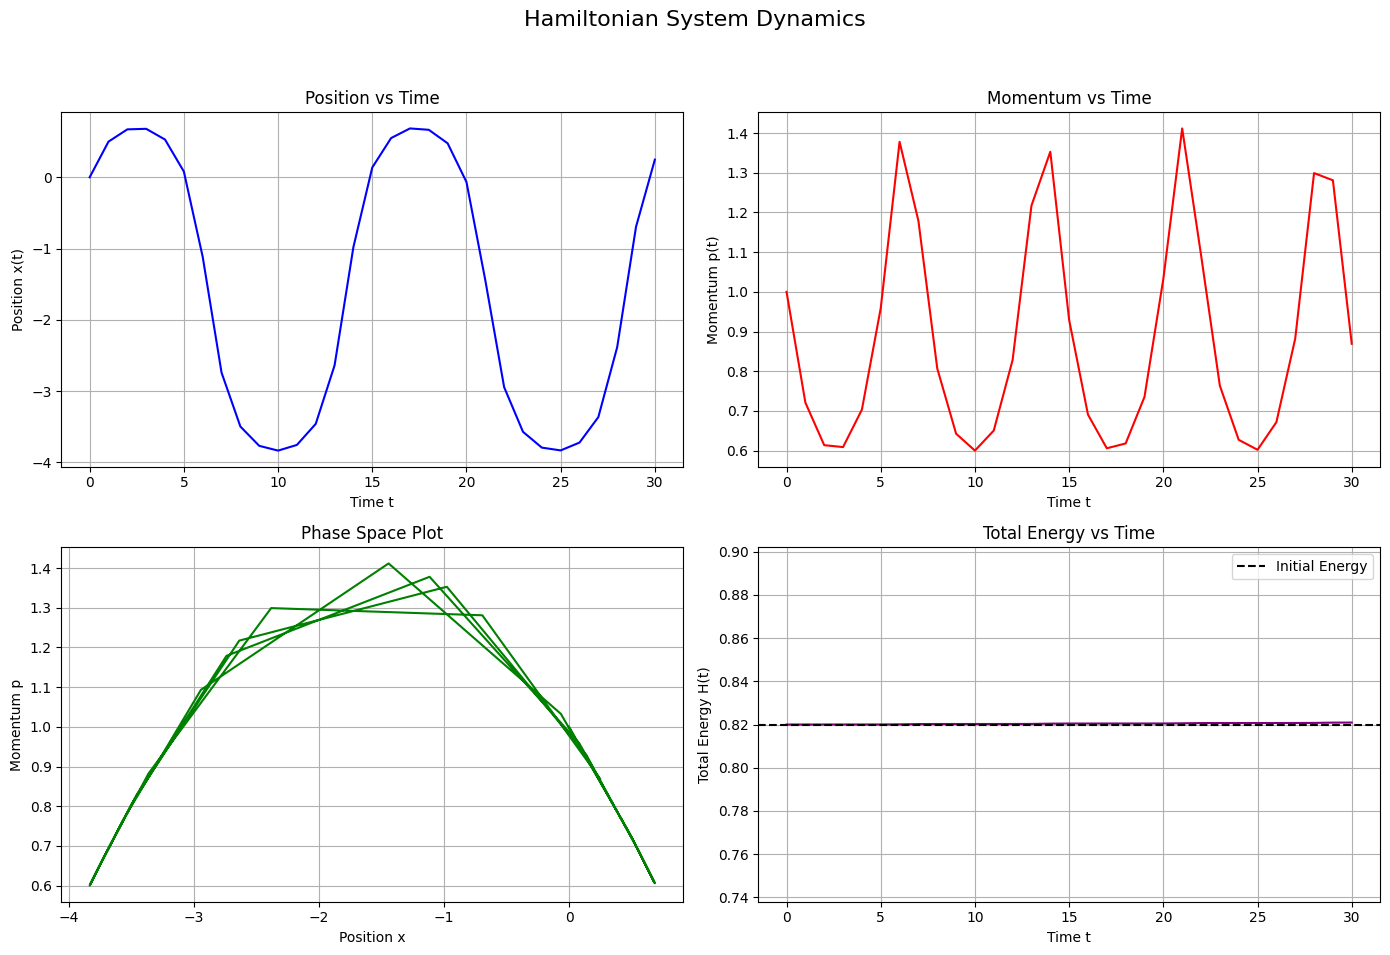

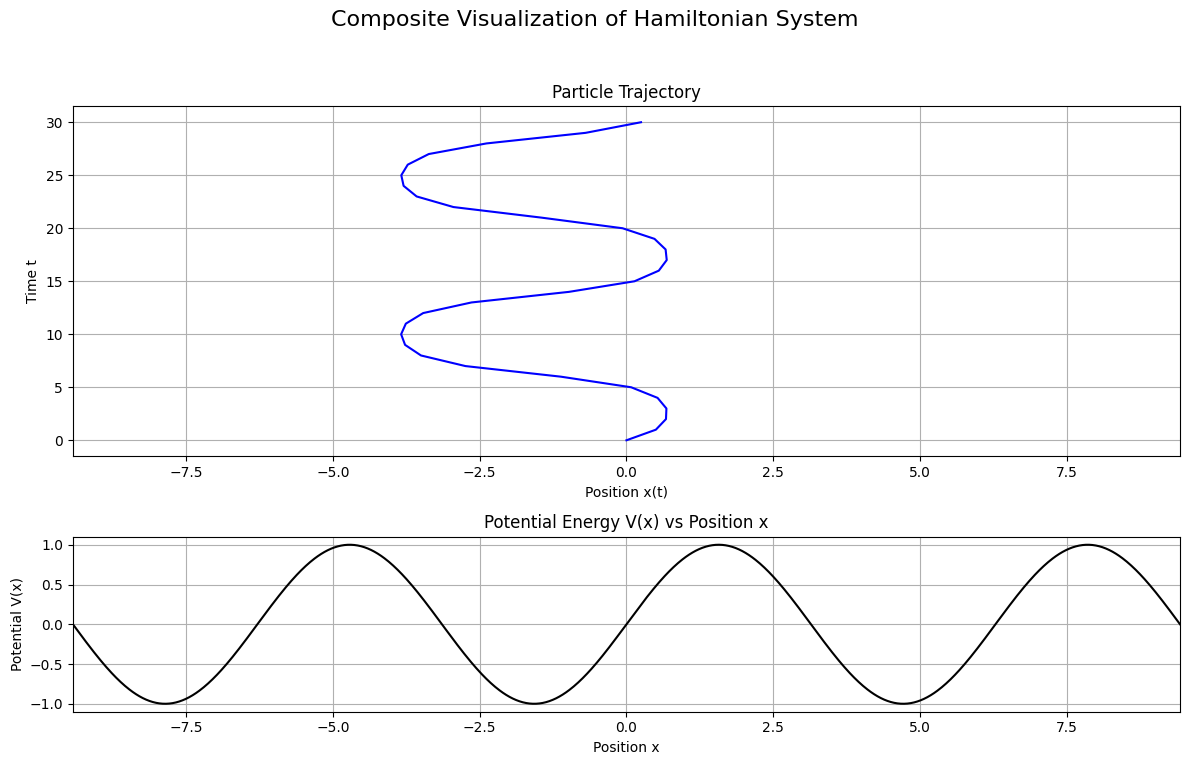

In [3]:
'''
H = p^2 / 2 + sin(x) + r^2 / 2
G = r^2 / 2 + sin(x) / 2

x_dot = dH/dp * dG/dr - dH/dr * dG/dp = p * r - r * 0
p_dot = dH/dr * dG/dx - dH/dx * dG/dr = r * cos(x)/2 - cos(x) * r
r_dot = dH/dx * dG/dp - dH/dp * dG/dx = cos(x) * 0 - p * cos(x)/2
'''

# Define the parameters
t_max = 30.0  # Maximum time
delta_t = 0.0001  # Time step

def x_dot(x, p, r):
    return p * r

def p_dot(x, p, r):
    return r * np.cos(x) / 2 - np.cos(x) * r

def r_dot(x, p, r):
    return - p * np.cos(x) / 2

# Create Hamiltonian system
nambu_system = NambuSystem(x_dot, p_dot, r_dot, t_max, delta_t)

# Fixed initial condition
x0, p0, r0 = 0.0, 1.0, 0.8

# Simulate for the fixed initial condition
t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)

# Sample the data
t_sampled, x_sampled, p_sampled, r_sampled = nambu_system.sample_data(t_array, x_array, p_array, r_array)

# Calculate energy
energy_sampled = 0.5 * (p_sampled**2) + np.sin(x_sampled) + 0.5 * (r_sampled**2)
potential = lambda x: np.sin(x)

# Plotting
plotter = Plotter()
plotter.static_plots(t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.composite_plot(x_sampled, t_sampled, potential)

### Sampling different initial conditions

In [4]:
def sample_initial_conditions(N, x_bounds=(- np.pi, np.pi), psigma=1):
    """
    Sample N initial conditions (x0, p0) with probability proportional to exp(-H(x0, p0)),
    where H(x0, p0) = p0^2/(2m) + V(x0).

    Parameters:
        N (int): Number of samples to generate.
        x_bounds (tuple): Bounds for x0 sampling.
        psigma (float): Standard deviation for p0 sampling.

    Returns:
        List of tuples: [(x0_1, p0_1), (x0_2, p0_2), ..., (x0_N, p0_N)]
    """
    samples = []
    attempts = 0
    max_attempts = N * 1000  # To prevent infinite loop
    
    potential_min = min(potential(np.linspace(x_bounds[0], x_bounds[1], 1000)))
    print(f">>> Potential min: {potential_min}")

    while len(samples) < N and attempts < max_attempts:
        # Sample x0 uniformly within bounds
        x_proposal = np.random.uniform(x_bounds[0], x_bounds[1])
        # Compute acceptance probability for x0
        p_x = np.exp(-potential(x_proposal))
        p_x_max = np.exp(-potential_min)  # the minimum of potential corresponds to the maximum of p_x

        if np.random.uniform(0, p_x_max) < p_x:
            # Accept x0
            x0 = x_proposal
            # Sample p0 from Gaussian distribution
            p0 = np.random.normal(0, psigma)
            samples.append((x0, p0))
        attempts += 1
        
    if len(samples) < N:
        raise RuntimeError(f"Could not generate {N} samples within {max_attempts} attempts.")

    return samples

>>> Potential min: -0.9999950553174459

>>> Generated 500 sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))


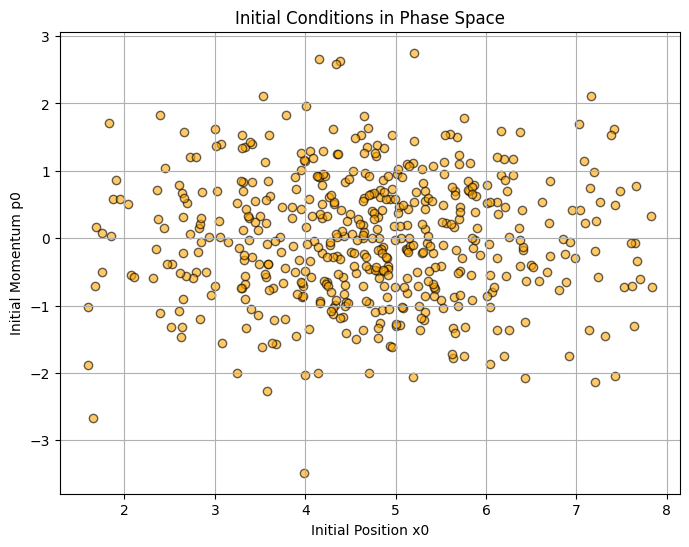

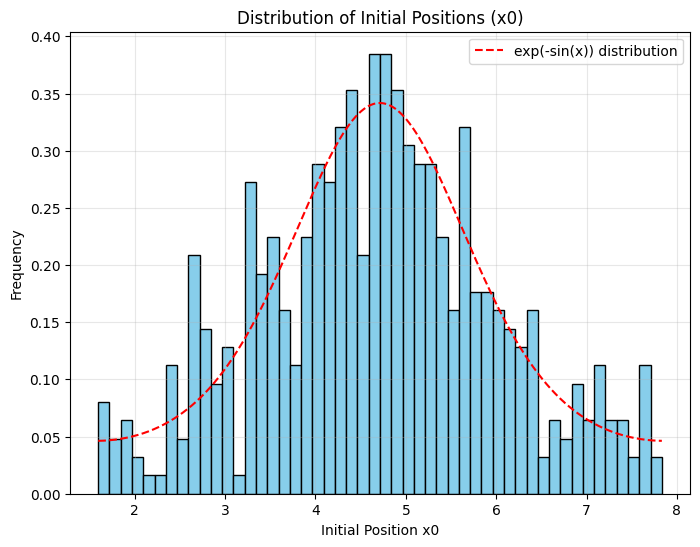

In [5]:
Nsamp = 500
sampled_initial_conditions = sample_initial_conditions(N=Nsamp, x_bounds=(np.pi / 2, 5 * np.pi / 2), psigma=np.sqrt(m))

print(f"\n>>> Generated {Nsamp} sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))")

# visualize the initial conditions in phase space
x0_samples, p0_samples = zip(*sampled_initial_conditions)
plt.figure(figsize=(8, 6))
plt.scatter(x0_samples, p0_samples, color='orange', alpha=0.6, edgecolor='k')
plt.title("Initial Conditions in Phase Space")
plt.xlabel("Initial Position x0")
plt.ylabel("Initial Momentum p0")
plt.grid(True)
plt.show()

# Create a histogram of x0_samples
plt.figure(figsize=(8, 6))
plt.hist(x0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(x0_samples), max(x0_samples), 1000)
theoretical_dist = np.exp(- np.sin(x_range)) / 7.955  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-sin(x)) distribution')
plt.title("Distribution of Initial Positions (x0)")
plt.xlabel("Initial Position x0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Calculate the average number of times crossing the potential maxima

In [6]:
x_search = np.linspace(-50, 50, 10000)
potential_values = potential(x_search)
local_maxima_indices = (
    np.where(
        (potential_values[1:-1] > potential_values[:-2])
        & (potential_values[1:-1] > potential_values[2:])
    )[0]
    + 1
)
local_maxima = x_search[local_maxima_indices]
print(f"\n>>> Local maxima of the potential function at:", local_maxima)


>>> Local maxima of the potential function at: [-48.68986899 -42.40924092 -36.12861286 -29.8479848  -23.55735574
 -17.27672767 -10.99609961  -4.71547155   1.57515752   7.85578558
  14.13641364  20.4170417   26.70767077  32.98829883  39.26892689
  45.54955496]


In [7]:
print(">>> Using Hamiltonian Dynamics: ")
times_of_crossing = []
for x0, p0 in tqdm(sampled_initial_conditions, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
    
    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

average_crossings = np.mean(times_of_crossing)
print(f"\n>>> Average number of times crossing the potential maxima: {average_crossings:.2f}")

>>> Using Hamiltonian Dynamics: 


Loop in samples: 100%|██████████| 500/500 [00:09<00:00, 50.10it/s]


>>> Average number of times crossing the potential maxima: 0.92


In [8]:
print(">>> Using Nambu Dynamics: ")
times_of_crossing = []
for x0, p0 in tqdm(sampled_initial_conditions, desc="Loop in samples"):
    r0 = 0.5
    # r0 = np.random.normal(0, 0.5)
    t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)
    
    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

average_crossings = np.mean(times_of_crossing)
print(f"\n>>> Average number of times crossing the potential maxima: {average_crossings:.2f}")

>>> Using Nambu Dynamics: 


Loop in samples:   8%|▊         | 38/500 [01:41<20:34,  2.67s/it]


KeyboardInterrupt: 